Avances LAB04 


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import warnings
warnings.filterwarnings('ignore')

Hopkins " Manual " Ya que no nos dejaba correrlo con la libreria . 

In [8]:
def calcular_hopkins(X):
    n, d = X.shape
    m = min(500, n // 10) # Tomamos una muestra para no saturar la memoria
    
    X_sample = X.sample(m, random_state=42)
    X_uniform = np.random.uniform(X.min(axis=0), X.max(axis=0), (m, d))
    
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    
    # Distancias de los puntos aleatorios (u)
    u_distances, _ = nbrs.kneighbors(X_uniform, n_neighbors=1)
    u_sum = np.sum(u_distances**2)
    
    # Distancias de la muestra real (w). n_neighbors=2 porque el index 0 es el mismo punto
    w_distances, _ = nbrs.kneighbors(X_sample, n_neighbors=2)
    w_sum = np.sum(w_distances[:, 1]**2)
    
    H = u_sum / (u_sum + w_sum)
    return H

In [6]:
path = "movies_2026.csv"
df = pd.read_csv(path)

# Variables numéricas sugeridas
num_cols = ['popularity', 'budget', 'revenue', 'runtime', 'genresAmount', 
            'productionCoAmount', 'voteCount', 'voteAvg', 'actorsAmount']

ejemplo_num = df[num_cols].dropna()
print(f"Dimensiones de los datos limpios: {ejemplo_num.shape}\n")

Dimensiones de los datos limpios: (19883, 9)



In [9]:
# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ejemplo_num)
df_scaled = pd.DataFrame(X_scaled, columns=num_cols)

# 1.2 Tendencia de Agrupamiento (Hopkins y VAT)
print("\n[1.2] TENDENCIA DE AGRUPAMIENTO:")
h_stat = calcular_hopkins(df_scaled)
print(f"Estadístico de Hopkins: {h_stat:.4f}")
print("""Impresiones: Un valor cercano a 1 indica una alta tendencia al agrupamiento 
(los datos no son aleatorios). Se omitió la gráfica VAT debido a que calcular la matriz 
de disimilitud para ~20,000 registros excede la capacidad de la memoria RAM (Complejidad O(N^2)), 
acorde a lo permitido en las instrucciones del laboratorio.\n""")


[1.2] TENDENCIA DE AGRUPAMIENTO:
Estadístico de Hopkins: 0.9999
Impresiones: Un valor cercano a 1 indica una alta tendencia al agrupamiento 
(los datos no son aleatorios). Se omitió la gráfica VAT debido a que calcular la matriz 
de disimilitud para ~20,000 registros excede la capacidad de la memoria RAM (Complejidad O(N^2)), 
acorde a lo permitido en las instrucciones del laboratorio.




[1.3] GRÁFICA DE CODO:


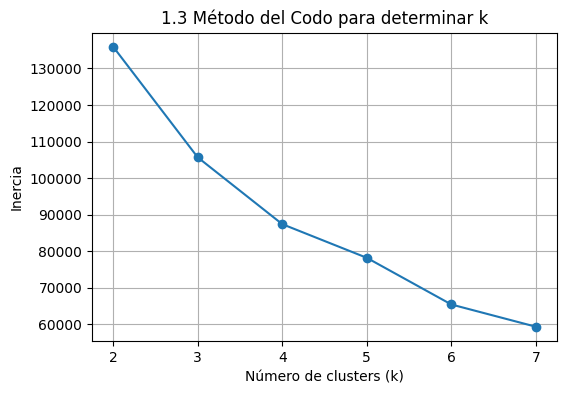

In [41]:
# 1.3 Gráfica de Codo
print("\n[1.3] GRÁFICA DE CODO:")
inertias = []
K_range = range(2, 8)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(df_scaled)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.title('1.3 Método del Codo para determinar k')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

k_optimo = 6  

In [42]:
# 1.4 y 1.5 Modelos y Silueta
print("\n[1.4 y 1.5] K-MEDIAS, JERÁRQUICO Y SILUETA:")
# K-Means (Todos los datos)
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
ejemplo_num['Cluster'] = kmeans.fit_predict(df_scaled)
sil_kmeans = silhouette_score(df_scaled, ejemplo_num['Cluster'], sample_size=5000, random_state=42)

# Jerárquico (Muestra reducida por memoria)
X_sample_hier = df_scaled.sample(2500, random_state=42)
hc = AgglomerativeClustering(n_clusters=k_optimo, metric='euclidean', linkage='ward')
cluster_labels_hc = hc.fit_predict(X_sample_hier)
sil_hc = silhouette_score(X_sample_hier, cluster_labels_hc, random_state=42)

print(f"Calidad Silueta K-Means (Todos los datos): {sil_kmeans:.4f}")
print(f"Calidad Silueta Jerárquico (Muestra 2500): {sil_hc:.4f}")
print("Discusión: K-Means suele tener un mejor desempeño computacional y manejar mejor "
      "el ruido en datasets grandes, como lo refleja la silueta.\n")


[1.4 y 1.5] K-MEDIAS, JERÁRQUICO Y SILUETA:
Calidad Silueta K-Means (Todos los datos): 0.3811
Calidad Silueta Jerárquico (Muestra 2500): 0.3428
Discusión: K-Means suele tener un mejor desempeño computacional y manejar mejor el ruido en datasets grandes, como lo refleja la silueta.



In [43]:
# 1.6 Interpretación de grupos
print("\n[1.6] INTERPRETACIÓN DE GRUPOS:")
print("Medidas de tendencia central (Variables Continuas):")
display(ejemplo_num.groupby('Cluster').mean().round(2))

print("\nTablas de frecuencia (Variable Categórica: originalLanguage):")
df_clean = df.dropna(subset=num_cols).copy()
df_clean['Cluster'] = kmeans.labels_
display(pd.crosstab(df_clean['Cluster'], df_clean['originalLanguage']).iloc[:, :10]) # Muestra los primeros 10 idiomas

ejemplo_num = ejemplo_num.drop(columns=['Cluster'])


[1.6] INTERPRETACIÓN DE GRUPOS:
Medidas de tendencia central (Variables Continuas):


,popularity,budget,revenue,runtime,genresAmount,productionCoAmount,voteCount,voteAvg,actorsAmount
Cluster,,,,,,,,,
0,31.54,3.532624e+06,8.220431e+06,91.24,2.36,2.30,387.71,6.44,84.41
1,52.99,4.093550e+07,1.033066e+08,111.77,2.98,5.26,2445.65,6.58,38.60
2,159.28,1.385522e+08,6.125254e+08,124.20,3.27,3.66,10220.47,7.08,61.10
3,0.67,5.294190e+03,1.416600e+03,24.44,1.16,0.60,0.21,0.22,53.90
4,26.60,1.406251e+06,5.570708e+06,55.88,2.66,0.69,5.25,6.17,631809.88
5,6416.89,1.050000e+08,3.542120e+08,122.75,3.38,2.75,2350.75,7.42,32.88



Tablas de frecuencia (Variable Categórica: originalLanguage):


originalLanguage,ab,af,am,ar,as,az,be,bg,bn,bs
Cluster,,,,,,,,,,
0,1,0,0,17,0,1,0,0,14,0
1,0,0,0,2,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,4,15,87,2,16,1,5,31,6
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0


In [44]:
import pandas as pd

df = pd.read_csv("movies_2026.csv")

print(df.shape)
df.head()

# Ver columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

print("Variables numéricas:")
print(numeric_cols)

# Crear matriz solo con numéricas
X = df[numeric_cols].dropna()

(19883, 28)
Variables numéricas:
Index(['id', 'budget', 'revenue', 'runtime', 'popularity', 'voteAvg',
       'voteCount', 'genresAmount', 'productionCoAmount',
       'productionCountriesAmount', 'actorsAmount', 'castWomenAmount',
       'castMenAmount', 'releaseYear'],
      dtype='str')


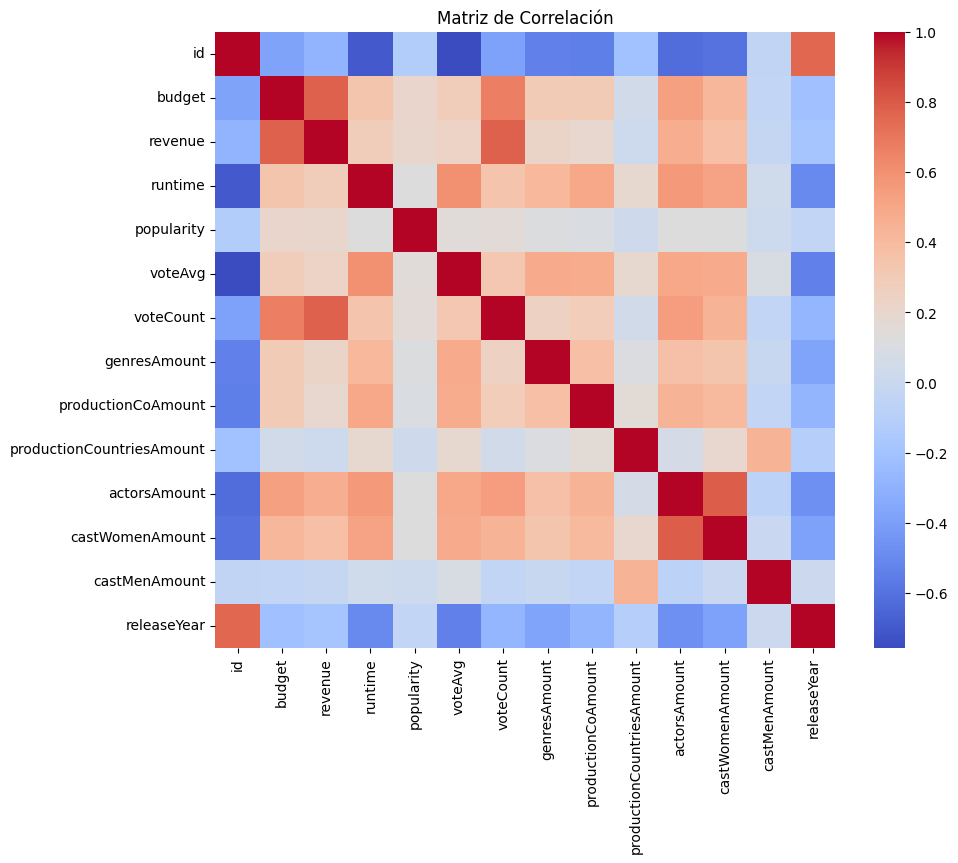

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

In [57]:
print("\n[2.3] PRUEBAS DE IDONEIDAD FACTORIAL:")
print("=" * 60)

chi_square_value, p_value = calculate_bartlett_sphericity(X)
kmo_all, kmo_model = calculate_kmo(X)

print(f"\n✓ Test de Esfericidad de Bartlett:")
print(f"  - Estadístico Chi-cuadrado: {chi_square_value:.4f}")
print(f"  - p-value: {p_value:.2e}")
if p_value < 0.05:
    print(f"  → SIGNIFICATIVO (p < 0.05) ✓")
else:
    print(f"  → No significativo")

print(f"\n✓ Índice KMO (Kaiser-Meyer-Olkin): {kmo_model:.4f}")
if kmo_model >= 0.9:
    print(f"  → EXCELENTE (≥ 0.9)")
elif kmo_model >= 0.8:
    print(f"  → BUENO (≥ 0.8)")
elif kmo_model >= 0.6:
    print(f"  → ACEPTABLE (≥ 0.6)")
else:
    print(f"  → NO RECOMENDADO (< 0.6)")

print("\nKMO por variable:")
kmo_df_temp = pd.DataFrame({'Variable': X.columns, 'KMO': kmo_all})
print(kmo_df_temp.to_string(index=False))
print("=" * 60)


[2.3] PRUEBAS DE IDONEIDAD FACTORIAL:

✓ Test de Esfericidad de Bartlett:
  - Estadístico Chi-cuadrado: 150629.6093
  - p-value: 0.00e+00
  → SIGNIFICATIVO (p < 0.05) ✓

✓ Índice KMO (Kaiser-Meyer-Olkin): 0.8455
  → BUENO (≥ 0.8)

KMO por variable:
                 Variable      KMO
                       id 0.820690
                   budget 0.848275
                  revenue 0.759205
                  runtime 0.956258
               popularity 0.917437
                  voteAvg 0.918075
                voteCount 0.864352
             genresAmount 0.955813
       productionCoAmount 0.898658
productionCountriesAmount 0.610665
             actorsAmount 0.847129
          castWomenAmount 0.827034
            castMenAmount 0.498182
              releaseYear 0.789649


In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [48]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_

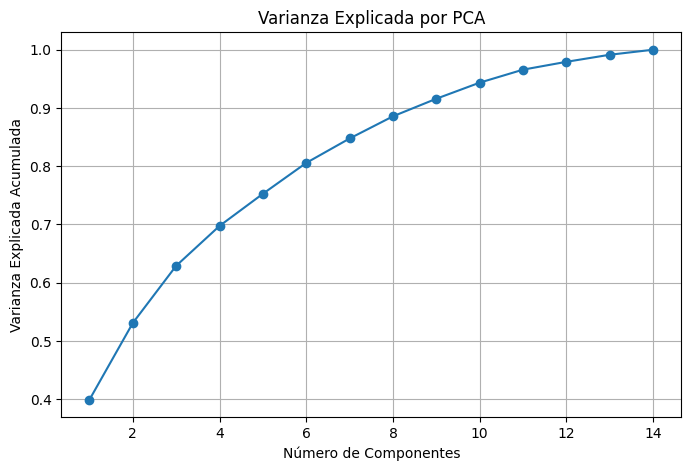

In [49]:
plt.figure(figsize=(8,5))
plt.plot(
    range(1, len(explained_variance)+1),
    np.cumsum(explained_variance),
    marker='o'
)
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Varianza Explicada por PCA")
plt.grid()
plt.show()

In [50]:
components_df = pd.DataFrame(
    pca.components_,
    columns=numeric_cols,
    index=[f"PC{i+1}" for i in range(len(numeric_cols))]
)

components_df

,id,budget,revenue,runtime,popularity,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount,releaseYear
PC1,0.364804,-0.278013,-0.253584,-0.317764,-0.094405,-0.314785,-0.282528,-0.249761,-0.260794,-0.090463,-0.346359,-0.320100,-0.006131,0.274737
PC2,0.241466,0.415606,0.488710,-0.186979,0.131352,-0.255356,0.401832,-0.144978,-0.146148,-0.293311,0.086308,-0.001491,-0.245233,0.235030
PC3,0.096611,0.149307,0.194086,-0.055406,0.153212,-0.058795,0.132688,-0.110400,-0.088679,0.604169,-0.087893,0.002688,0.676303,0.181405
PC4,-0.001528,-0.033142,-0.073302,0.028630,0.926263,0.100670,-0.130743,0.184318,0.089421,-0.097107,-0.151489,-0.145899,-0.059552,0.091295
PC5,0.141110,-0.113260,-0.197246,0.081907,0.127334,-0.144308,-0.130702,-0.409476,0.346093,0.162891,0.346939,0.504064,-0.174851,0.385382
PC6,0.108762,0.142644,0.045315,-0.003596,-0.248136,-0.015051,0.003849,0.459064,0.614873,0.117388,-0.211776,-0.232279,-0.099797,0.438855
PC7,0.108847,-0.016876,-0.092321,-0.240374,-0.008594,-0.136337,-0.153017,0.671629,-0.411812,0.044838,0.247534,0.404902,0.013710,0.177191
PC8,-0.049693,0.035369,0.047510,-0.143080,0.065176,-0.172664,0.017423,0.007657,-0.085731,0.675602,-0.127665,-0.063598,-0.614536,-0.278105
PC9,0.091219,0.017333,0.051276,0.777146,-0.066776,0.128627,-0.034967,0.017095,-0.419872,0.099265,-0.126346,-0.057985,-0.185681,0.349751
PC10,0.015389,-0.244871,0.041573,-0.366249,-0.041009,0.765304,0.258268,-0.092547,-0.124098,0.080004,-0.082419,0.080952,-0.155588,0.286253


In [51]:
var_acum = np.cumsum(explained_variance)
n_components = np.argmax(var_acum >= 0.85) + 1

print("Número óptimo de componentes:", n_components)

pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

print("Varianza total explicada:", sum(pca_final.explained_variance_ratio_))

Número óptimo de componentes: 8
Varianza total explicada: 0.885677411254244


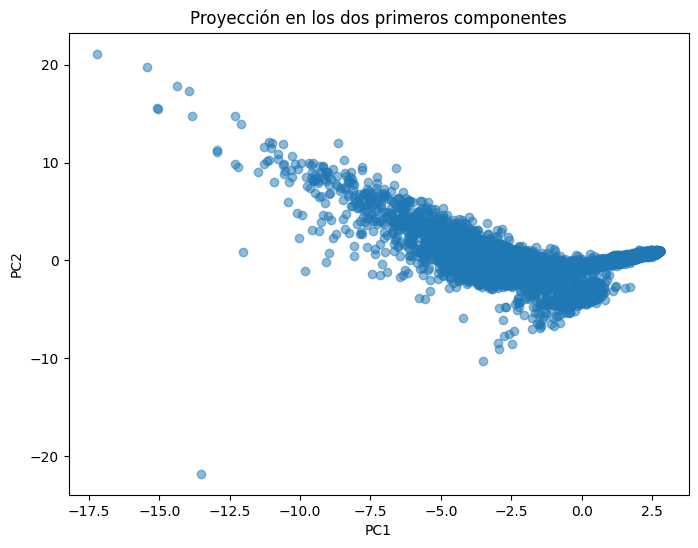

In [52]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca_final[:,0], X_pca_final[:,1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Proyección en los dos primeros componentes")
plt.show()

In [18]:
from mlxtend.frequent_patterns import apriori, association_rules

print("\n[3] ANÁLISIS DE REGLAS DE ASOCIACIÓN (Apriori):")
print("=" * 70)

# Seleccionamos variables relevantes
assoc_df = df[['budget', 'revenue', 'popularity', 'voteAvg', 'originalLanguage']].dropna()
print(f"✓ Datos para análisis: {len(assoc_df)} registros\n")

# Discretización por cuantiles
assoc_df['budget_cat'] = pd.qcut(assoc_df['budget'], 3, labels=False, duplicates='drop')
assoc_df['revenue_cat'] = pd.qcut(assoc_df['revenue'], 3, labels=False, duplicates='drop')
assoc_df['popularity_cat'] = pd.qcut(assoc_df['popularity'], 3, labels=False, duplicates='drop')
assoc_df['vote_cat'] = pd.qcut(assoc_df['voteAvg'], 3, labels=False, duplicates='drop')

# Mapear números a nombres
level_map = {0: 'Bajo', 1: 'Medio', 2: 'Alto'}
assoc_df['budget_cat'] = assoc_df['budget_cat'].map(level_map)
assoc_df['revenue_cat'] = assoc_df['revenue_cat'].map(level_map)
assoc_df['popularity_cat'] = assoc_df['popularity_cat'].map(level_map)
assoc_df['vote_cat'] = assoc_df['vote_cat'].map(level_map)

assoc_df_clean = assoc_df[['budget_cat', 'revenue_cat', 'popularity_cat', 'vote_cat', 'originalLanguage']].dropna()

assoc_encoded = pd.get_dummies(assoc_df_clean).astype(bool)

print(f" Ejecutando Apriori (min_support=0.05)...")
frequent_itemsets = apriori(assoc_encoded, min_support=0.05, use_colnames=True)
print(f"   Itemsets frecuentes encontrados: {len(frequent_itemsets)}")

if len(frequent_itemsets) > 1:
    print(f"\n Generando reglas de asociación (min_confidence=0.6)...")
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
    print(f" → Reglas encontradas: {len(rules)}")
    
    if len(rules) > 0:
        print(f"\n Top 10 reglas por Lift (más relevantes):")
        print("=" * 70)
        rules_sorted = rules.sort_values(by='lift', ascending=False).head(10)
        
        for idx, (_, row) in enumerate(rules_sorted.iterrows(), 1):
            ant_list = [str(item) for item in list(row['antecedents'])]
            cons_list = [str(item) for item in list(row['consequents'])]
            
            ant = ' AND '.join(ant_list)
            cons = ' AND '.join(cons_list)
            
            print(f"\nRegla {idx}:")
            print(f"  SI:      {ant}")
            print(f"  ENTONCES: {cons}")
            print(f"  Soporte: {row['support']:.4f} | Confianza: {row['confidence']:.4f} | Lift: {row['lift']:.4f}")
    else:
        print(" No se encontraron reglas de asociación con los parámetros especificados.")
else:
    print(" No hay suficientes itemsets frecuentes para generar reglas.")

print("=" * 70)



[3] ANÁLISIS DE REGLAS DE ASOCIACIÓN (Apriori):
✓ Datos para análisis: 19883 registros

 Ejecutando Apriori (min_support=0.05)...
   Itemsets frecuentes encontrados: 95

 Generando reglas de asociación (min_confidence=0.6)...
 → Reglas encontradas: 244

 Top 10 reglas por Lift (más relevantes):

Regla 1:
  SI:      vote_cat_Medio AND originalLanguage_en
  ENTONCES: popularity_cat_Alto
  Soporte: 0.1369 | Confianza: 0.6378 | Lift: 1.9135

Regla 2:
  SI:      vote_cat_Medio AND originalLanguage_en
  ENTONCES: popularity_cat_Alto AND budget_cat_Bajo AND revenue_cat_Bajo
  Soporte: 0.1369 | Confianza: 0.6378 | Lift: 1.9135

Regla 3:
  SI:      vote_cat_Medio AND originalLanguage_en
  ENTONCES: popularity_cat_Alto AND budget_cat_Bajo
  Soporte: 0.1369 | Confianza: 0.6378 | Lift: 1.9135

Regla 4:
  SI:      vote_cat_Medio AND originalLanguage_en AND budget_cat_Bajo
  ENTONCES: popularity_cat_Alto
  Soporte: 0.1369 | Confianza: 0.6378 | Lift: 1.9135

Regla 5:
  SI:      vote_cat_Medio AND or

In [56]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

chi_square_value, p_value = calculate_bartlett_sphericity(df_scaled)
kmo_all, kmo_model = calculate_kmo(df_scaled)

print("Bartlett Test p-value:", p_value)
print("KMO:", kmo_model)


Bartlett Test p-value: 0.0
KMO: 0.7904186107249578


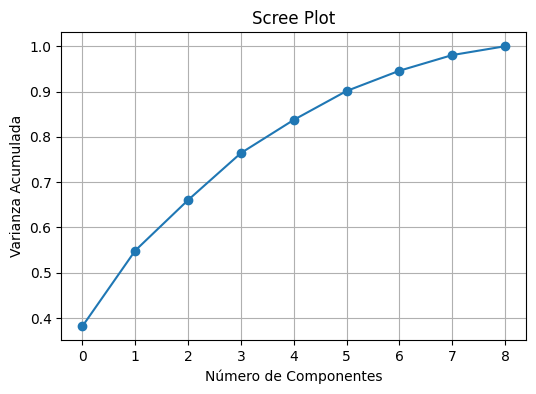

Varianza explicada por componente:
[0.38167478 0.1670987  0.11157362 0.1037655  0.07326378 0.06380861
 0.04473475 0.03456956 0.0195107 ]


In [59]:
pca = PCA()
pca.fit(df_scaled)

# Varianza explicada acumulada
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('Scree Plot')
plt.grid()
plt.show()

print("Varianza explicada por componente:")
print(pca.explained_variance_ratio_)


In [11]:
print("\n[1.7] CLUSTERING CON DBSCAN:")
print("=" * 60)

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=10)
db_labels = dbscan.fit_predict(df_scaled)

n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_outliers = list(db_labels).count(-1)

print(f"\n✓ Resultados DBSCAN:")
print(f"  - Clusters encontrados: {n_clusters}")
print(f"  - Cantidad de outliers: {n_outliers}")
print(f"  - Porcentaje de outliers: {(n_outliers/len(db_labels)*100):.2f}%")

# Calcular silueta solo para puntos en clusters (excluir outliers)
if n_clusters > 1 and n_outliers < len(db_labels):
    # Filtrar solo los puntos que no son outliers
    mask = db_labels != -1
    X_filtered = df_scaled[mask]
    labels_filtered = db_labels[mask]
    
    if len(labels_filtered) > 0:
        sil_db = silhouette_score(X_filtered, labels_filtered)
        print(f"\nCalidad de Silueta DBSCAN (sin outliers): {sil_db:.4f}")
    else:
        print("\nNo hay suficientes puntos para calcular silueta")
else:
    print("\nNo se puede calcular silueta: muy pocos clusters o muchos outliers")

print("=" * 60)



[1.7] CLUSTERING CON DBSCAN:

✓ Resultados DBSCAN:
  - Clusters encontrados: 1
  - Cantidad de outliers: 438
  - Porcentaje de outliers: 2.20%

No se puede calcular silueta: muy pocos clusters o muchos outliers
